Проект

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

from tqdm import tqdm

sns.set(font_scale=1.5, palette='Set2')

Научимся генерировать случайный граф модели Эрдеша-Реньи.

In [2]:
def GenerateRandomGraph(n, p):
    if p < 0.4:
        g = nx.fast_gnp_random_graph(n, p, directed=True)
    else:
        g = nx.erdos_renyi_graph(n, p, directed=True)
        
    edges = set()
    for edge in g.edges:
        u, v = edge[0], edge[1]
        pair = (v, u)
        if pair not in edges:
            edges.add(edge)
            
    g.clear_edges()
    g.add_edges_from(edges)
    return g
        

In [3]:
def PrintGraph(g: nx.DiGraph, a, ax, title):
    pos = nx.spring_layout(g, seed=3114652)
    
    b = []
    for edge in g.edges:
        if edge not in a:
            b.append(edge)
    
    nx.draw_networkx_nodes(
        g, 
        pos,
        ax=ax,
        node_color='black',
        node_size=100,
        alpha=0.9
    )
    
    nx.draw_networkx_edges(
        g, 
        pos, 
        ax=ax,
        edgelist=a,
        width=2,
        alpha=0.9,
        edge_color="tab:red",
        arrowstyle="->",
        arrowsize=30
    )
    
    nx.draw_networkx_edges(
        g, 
        pos, 
        ax=ax,
        edgelist=b,
        width=2,
        alpha=0.6,
        edge_color="black",
        arrowstyle="->",
        arrowsize=30
    )
    
    ax.set_title(title)
    ax.set_xlabel("Number of edges: {}".format(len(a)))


Реализация основных алгоритмов:

In [4]:
def ReduceSink(g: nx.DiGraph, s):
    while True:
        found = False
        for n in g.nodes:
            if g.out_degree(n) == 0:
                s.insert(0, n)
                g.remove_node(n)
                found = True
                break
                
        if not found:
            return
        

def ReduceSource(g: nx.DiGraph, s):
    while True:
        found = False
        for n in g.nodes:
            if g.in_degree(n) == 0:
                s.append(n)
                g.remove_node(n)
                found = True
                break
                
        if not found:
            return

def GetPermutation(g: nx.DiGraph, random=True):
    if random:
        return np.random.permutation(g.nodes)
    
    q = g.copy()
    s1, s2 = [], []
    
    while q.number_of_nodes() > 0:
        ReduceSink(q, s2)
        ReduceSource(q, s1)
        
        delta = -1
        v = -1
    
        for n in q.nodes():
            cur_delta = q.out_degree(n) - q.in_degree(n)
            if v == -1 or delta < cur_delta:
                delta = cur_delta
                v = n
        
        if v != -1:
            s1.append(v)
            q.remove_node(v)
            
    return s1 + s2
    
    

def GetMaxAcyclicSubgraph(g: nx.DiGraph, random=True):
    perm = GetPermutation(g, random)
    
    A = []
    B = []
    
    for edge in g.edges:
        from_id, to_id = perm[edge[0]], perm[edge[1]]
        if from_id > to_id:
            A.append(edge)
        else:
            B.append(edge)
            
    if len(A) < len(B):
        A, B = B, A
        
    return A
  

Экспоненциальный алгоритм поиска максимального числа ребер:

In [5]:
def HasCycle(g: nx.DiGraph):
    try:
        nx.algorithms.cycles.find_cycle(g)
    except:
        return False
    return True

def GetMaxAcyclicSubgraphNP(g: nx.DiGraph):
    result = []
    cur_ans = 0
    
    sz = g.number_of_edges()
    for i in range(1, sz + 1):
        for subset in itertools.combinations(g.edges, i):
            new_g = nx.DiGraph(subset)
            if not HasCycle(new_g) and cur_ans < i:
                cur_ans = i
                result = subset
                break
    return result
  

Проверка работы алгоритмов для конкретных графов:

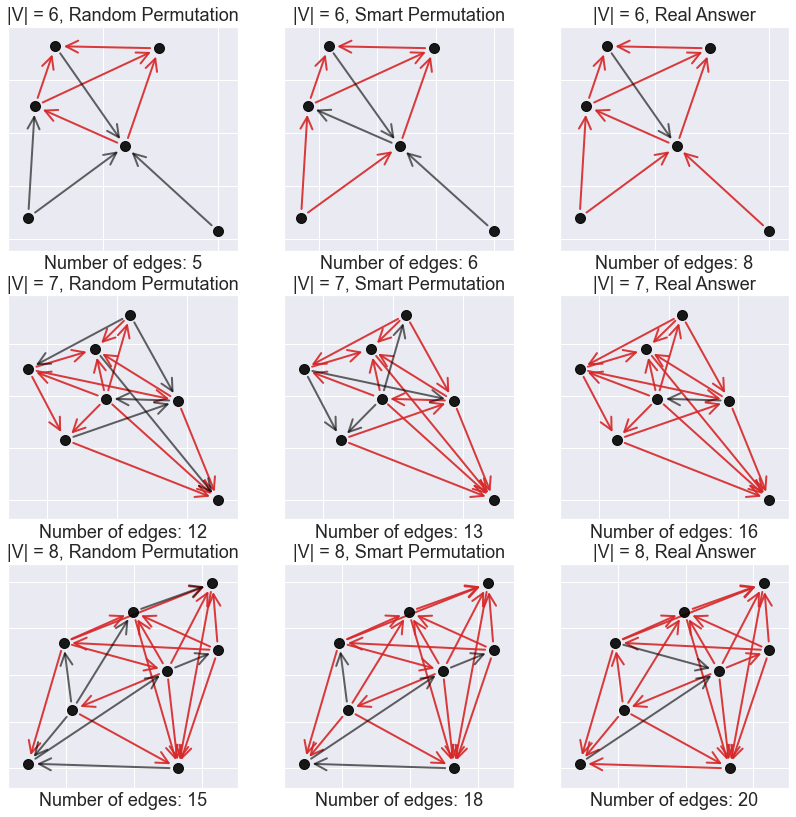

In [28]:
fig, axs = plt.subplots(3, 3, figsize=(14, 14))

for i, n in enumerate([6, 7, 8]):
    K = GenerateRandomGraph(n, 0.5)
    A = GetMaxAcyclicSubgraph(K, random=True)
    B = GetMaxAcyclicSubgraph(K, random=False)
    C = GetMaxAcyclicSubgraphNP(K)
    
    PrintGraph(K, A, axs[i][0], "|V| = {}, Random Permutation".format(n))
    PrintGraph(K, B, axs[i][1], "|V| = {}, Smart Permutation".format(n))
    PrintGraph(K, C, axs[i][2], "|V| = {}, Real Answer".format(n))

plt.show()

Посмотрим, какие результаты в среднем выдают данные алгоритмы для малых размеров графов для различных вероятносей $p$ в модели $G(n, p)$: 

In [29]:
def generate_data(n_vals, n_steps, p, real_ans=False):
    random_res = []
    smart_res = []
    real_res = []

    for n in n_vals:
        current_random_res = []
        current_smart_res = []
        current_real_res = []

        for _ in range(n_steps):
            K = GenerateRandomGraph(n, p)
            a = len(GetMaxAcyclicSubgraph(K, random=True))
            b = len(GetMaxAcyclicSubgraph(K, random=False))
            current_random_res.append(a)
            current_smart_res.append(b)
            
            if real_ans:
                c = len(GetMaxAcyclicSubgraphNP(K))
                current_real_res.append(c)

        random_res.append(np.mean(current_random_res))
        smart_res.append(np.mean(current_smart_res))
        
        if real_ans:
            real_res.append(np.mean(current_real_res))
    
    return random_res, smart_res, real_res


6it [02:14, 22.37s/it]


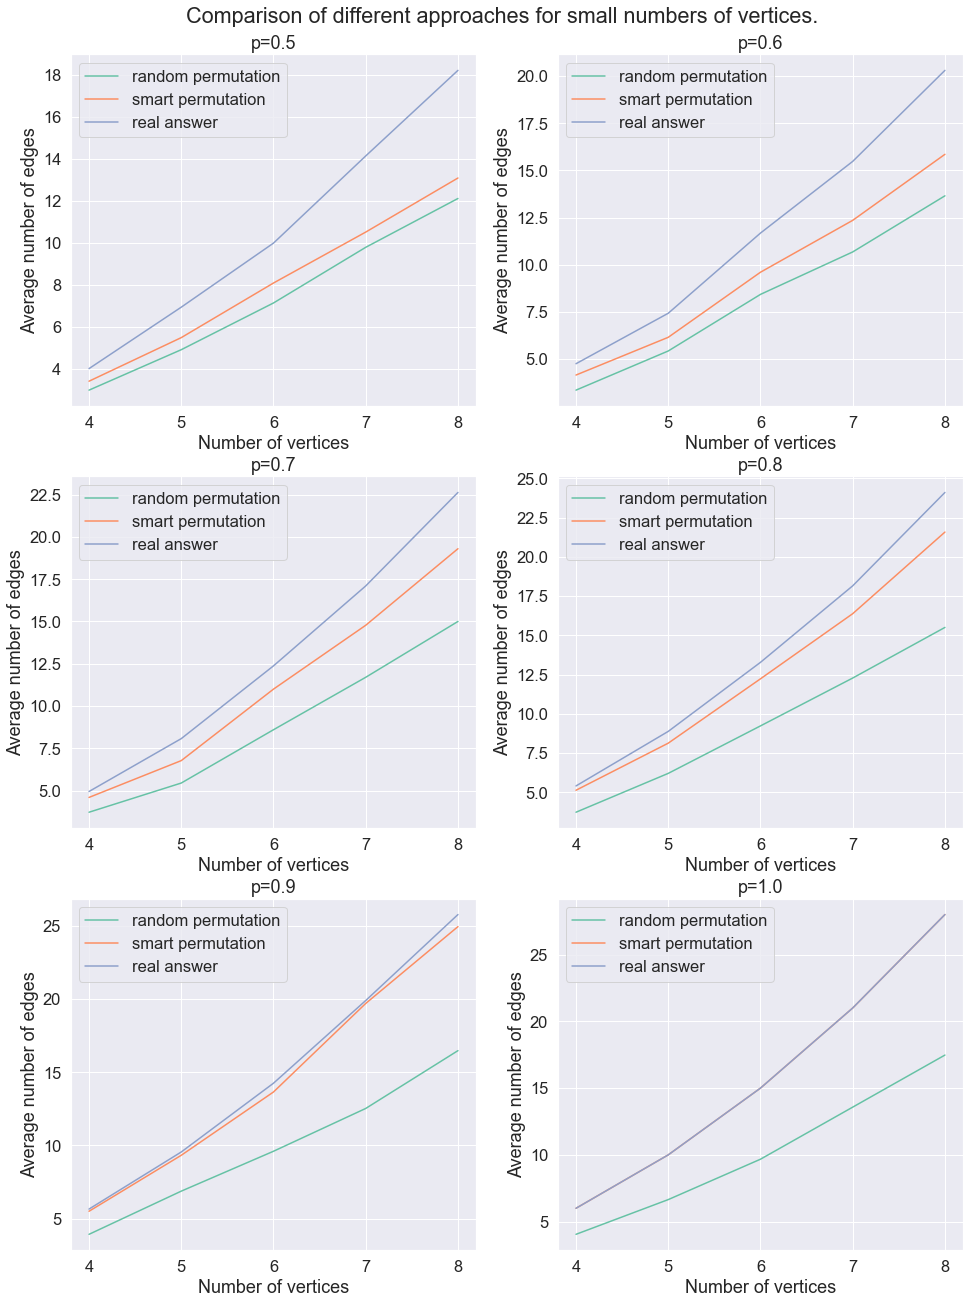

In [30]:
n_vals = np.arange(4, 9)
n_steps = 40
p_vals = np.linspace(0.5, 1, 6)

fig, axs = plt.subplots(3, 2, figsize=(16, 22))

for i, p in tqdm(enumerate(p_vals)):
    random_res, smart_res, real_res = generate_data(n_vals, n_steps, p, real_ans=True)
    ax = axs[i // 2][i % 2]
    
    ax.plot(n_vals, random_res, label="random permutation")
    ax.plot(n_vals, smart_res, label="smart permutation")
    ax.plot(n_vals, real_res, label="real answer")
    ax.legend()
    ax.set_xlabel("Number of vertices")
    ax.set_ylabel("Average number of edges")
    ax.set_title("p={}".format(p))

plt.suptitle("Comparison of different approaches for small numbers of vertices.", y = 0.91)
plt.show()

Также проведем запуски для больших размеров графов, при этом уже не запуская переборный алгоритм, который не выдаст ответ за адекватное время:

10it [26:40, 160.02s/it]


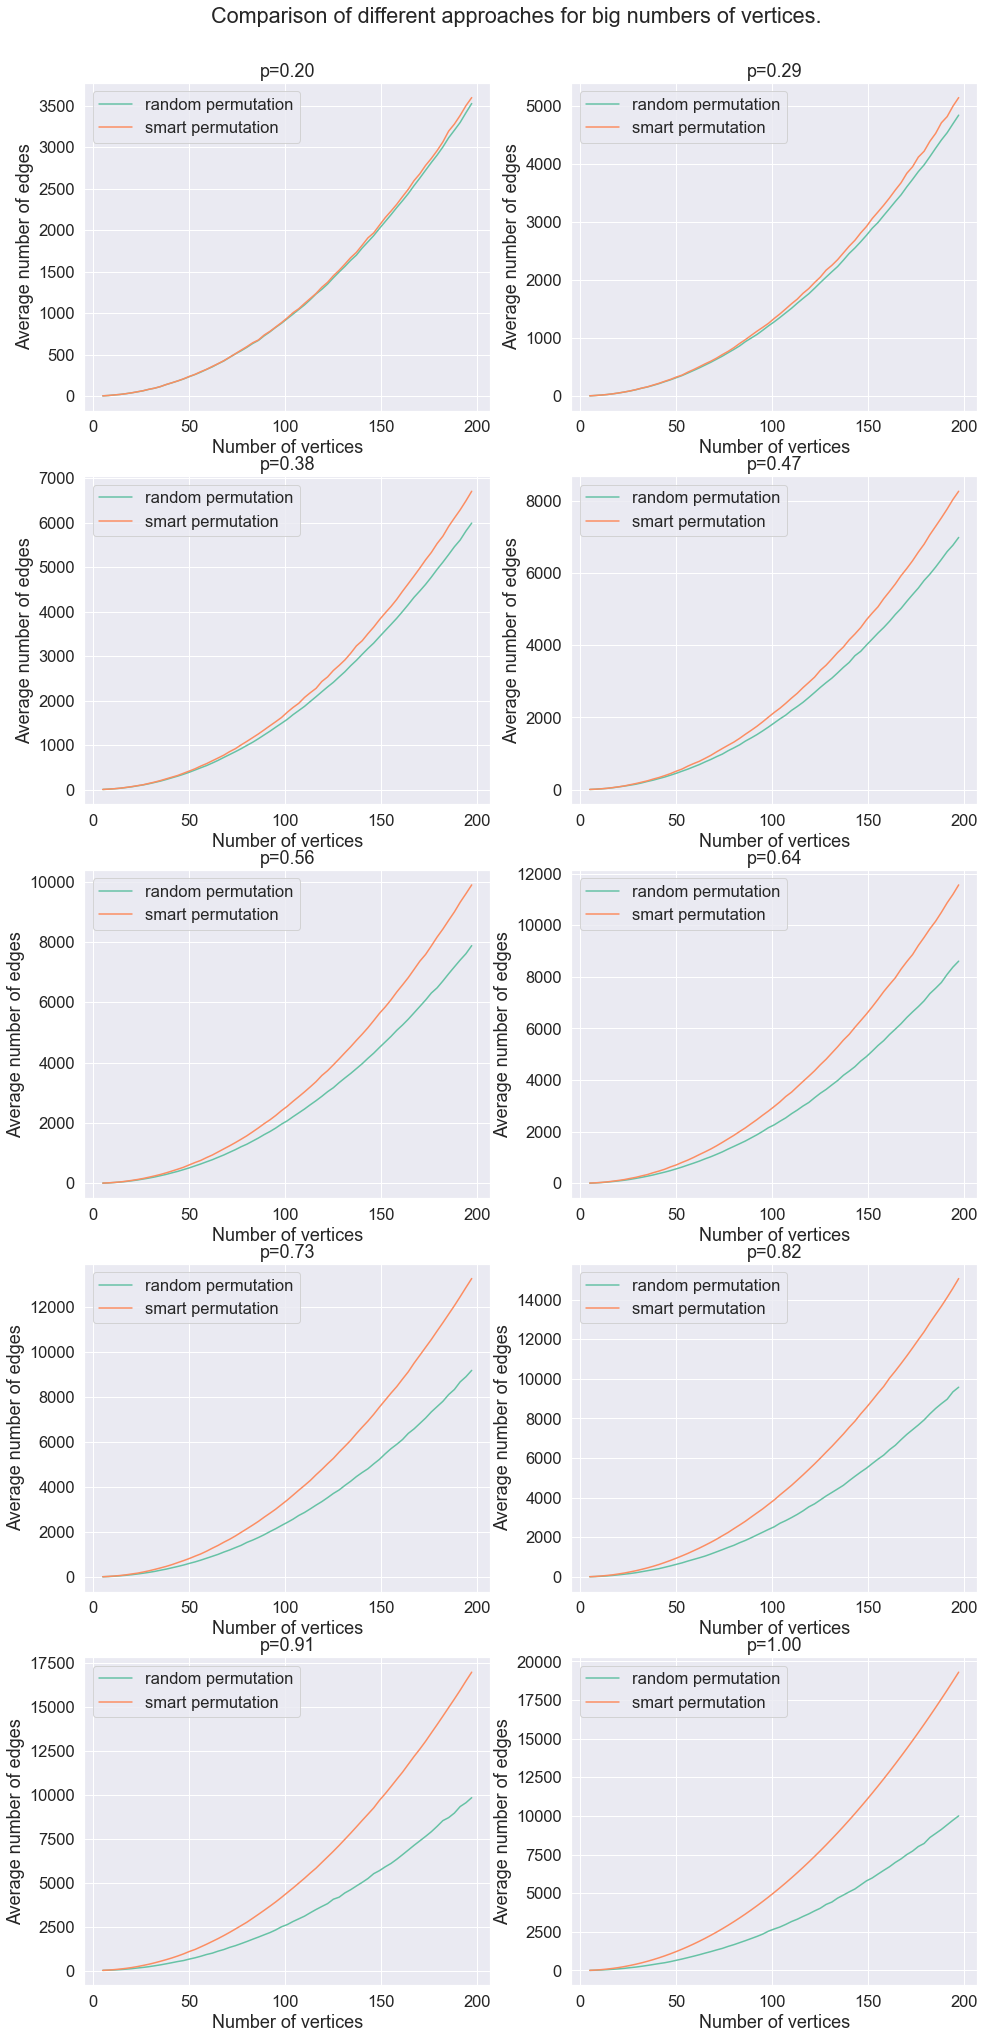

In [31]:
n_vals = np.arange(5, 200, 3)
n_steps = 40
p_vals = np.linspace(0.2, 1, 10)

fig, axs = plt.subplots(5, 2, figsize=(16, 35))

for i, p in tqdm(enumerate(p_vals)):
    random_res, smart_res, _ = generate_data(n_vals, n_steps, p)
    ax = axs[i // 2][i % 2]
    
    ax.plot(n_vals, random_res, label="random permutation")
    ax.plot(n_vals, smart_res, label="smart permutation")
    ax.legend()
    ax.set_xlabel("Number of vertices")
    ax.set_ylabel("Average number of edges")
    ax.set_title("p={:.2f}".format(p))

plt.suptitle("Comparison of different approaches for big numbers of vertices.", y = 0.91)
plt.show()

Зафиксируем конкретный размер графа и посмотрим на средний размер найденного ациклического подграфа в зависимости от различных значений вероятности $p$: 

In [32]:
p_vals = np.linspace(0, 1, 50)
n_steps = 40
n = 100

random_res = []
smart_res = []

for p in tqdm(p_vals):
    cur_rand = []
    cur_smart = []
    
    for _ in range(n_steps):
        K = GenerateRandomGraph(n, p)
        a = len(GetMaxAcyclicSubgraph(K, random=True))
        b = len(GetMaxAcyclicSubgraph(K, random=False))
        cur_rand.append(a)
        cur_smart.append(b)
            

    random_res.append(np.mean(cur_rand))
    smart_res.append(np.mean(cur_smart))

100%|███████████████████████████████████████████████████████████████████████| 50/50 [01:23<00:00,  1.67s/it]


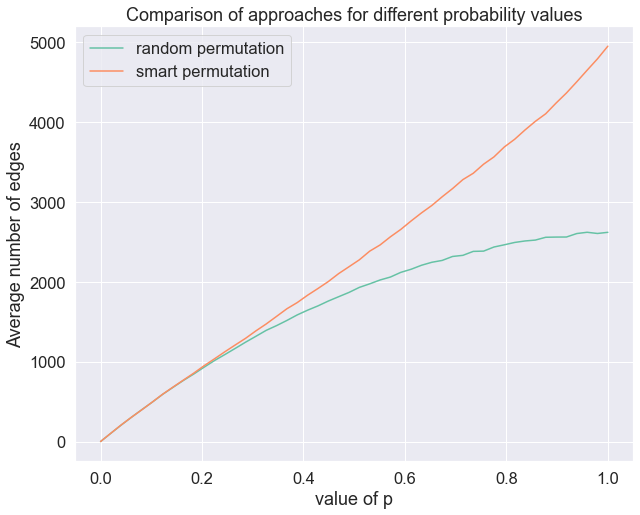

In [33]:
plt.figure(figsize=(10, 8))
plt.plot(p_vals, random_res, label="random permutation")
plt.plot(p_vals, smart_res, label="smart permutation")
plt.legend()
plt.title("Comparison of approaches for different probability values")
plt.xlabel("value of p")
plt.ylabel("Average number of edges")
plt.show()